第13章 取引戦略の第一歩

　日経平均株価に時間トレンドがあれば、投資すべきか。短期売買で収益を上げるには、季節性やアノマリーが必要か。ランダムウォークであれば投資を控えるべきか。 実際の価格の動きが高度な数学的な手法を用いてもモデル化できないのであれば、投資はあきらめるべきか。テクニカル分析は有効か。機械学習はどうか。しかし、今ここにある問いや疑問こそが道しるべとなる。やたらに疑問を発するのではなく、一定の方式を確立しなければならない。虚心坦懐に現象を分析すれば、機会を見失うことはない。試行錯誤と経験からの学習と熱望と緊張をもって問題に立ち向かう態度は、必ず道を開く。

生兵法は危うい！

　第5章を思い出してほしい。日経平均株価の日中の取引時間帯にどのような価格の動きがあるのか、取引が行われない時間帯にはどのような価格の動きがあるのかを分析した。日中の価格は下落しやすく、取引の行われない時間帯で価格が上昇しやすい現象を紹介した。つぎのグラフを見てほしい。

In [1]:
# フォントを全て読み込み
import matplotlib.pyplot as plt
import japanize_matplotlib

fonts = set([f.name for f in matplotlib.font_manager.fontManager.ttflist])
plt.rcParams['font.family'] = "MS Gothic"

In [2]:
import pandas as pd 
import pandas_datareader.data as web
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy.stats import t
from scipy.stats import chi2
from datetime import datetime,time 
import seaborn as sns

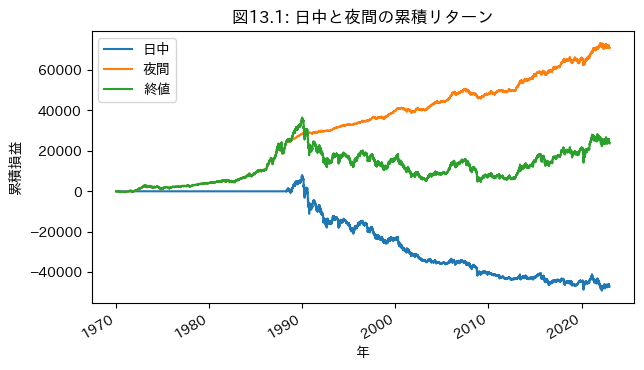

In [3]:
fig=plt.figure(figsize=(7,4))
analysis = pd.read_csv("^N225.csv",index_col=0,parse_dates=True).dropna()
analysis['intraday']=analysis.Close-analysis.Open
analysis['overnight']=analysis.Open-analysis.shift(1).Close
analysis.intraday.cumsum().plot(label='日中')
analysis.overnight.cumsum().plot(label='夜間')
(analysis.Close-analysis.iloc[0].Close).plot(label='終値')
plt.ylabel('累積損益')
plt.xlabel('年')
plt.legend()
plt.title('図13.1: 日中と夜間の累積リターン')
#plt.savefig("図13.1.jpeg",dpi=600)
plt.show()

　夜間取引を利用して取引することで安定した収益が見込めそうである。そこで、試してみよう。日経平均株価は日本を代表する株価指標であるが、それを直接売買できない。実際の取引は、指数採用全銘柄を売買するか、指数に連動する投資信託か先物を売買して行われる。日経225先物取引のデータを利用して同じ現象が見られるか否かを調べ、取引戦略を考えてみよう。
 
　現時点(2022/12/31)で日経平均株価に連動する先物は大阪取引所(大証)、シカゴ商業取引所(CME)、そしてシンガポール証券取引所(SGX)に上場されている。大証では、取引単位と呼値の刻みが異なるラージとミニの2つの先物が上場されている。ラージの取引単位は指数の1000倍、呼値の刻みは10円である。一方、ミニでは取引単位は指数の100倍、呼び値の刻みは5円である。決済はすべて差金決済される。

13.1 原点の確認

　第3章において本書の目的は、

**ネットワーク上にあるデータソースから金融経済関連データをダウンロードし、そのデータを分析し、安定した収益を生み出す投資・取引戦略を構築したい。**

であった。これをさらに具体的に表現しておこう。

**ネットワーク上にある日経平均株価のデータをダウンロードし、そのデータを分析し、先物1枚を用いて安定した収益を生み出す投資・取引戦略を構築したい。**

と取引の対象を日経225先物一枚に絞り込むことにしよう。

何が未知であるか？：将来の先物の動き

何が与えられているか？：過去の取引データ

条件は何か？先物1枚を取引し、損失を最小に抑え安定した利益を得る。

13.2 一定の方式を確立する

　どのような現象を分析するときにもまず標準となる方法があるはずだ。成功のカギは、はじめる前にある。そこで、ここでは最も基本的なところから始める。

 13.2.1 相手(先物取引)をよく知る
 
　先物とは、定められた場所(取引所)で、特定の商品(原資産)を将来のある時点で売買する枚数と価格を現時点で取り決める取引である。ここでいう将来のある時点は、取引所により予め定められている。また、取引価格の単位(呼値のきざみ)、取引金額の単位(取引単位)もあらかじめ定められている。さらに、取引には証拠金と呼ばれる担保を差し入れる必要がある。この制度により証拠金以上の額面の取引が可能となり、これをリバレッジ効果と呼ぶ。 
 
　日本の取引所取引には2つの取引方法がある。一方はザラバ方式と呼ばれる方法で、それは、最も高い価格の買い注文と最も安い価格の売り注文が出会う形で取引が成立する方法である。このような取引が行われる時間帯をレギュラー・セッションと呼ぶ。他方の板寄せ方式は、寄り付き(市場のはじまり)と引け(市場が終了)に行われるオークション方式である。こちらは価格優先、時間優先の規則にしたがい、取引の数量が最も多く、取引の成立しない数量が最も少なくなるように、約定価格を決める方式である。
 
　2016年7月19日から立会時間が変更になり、オープニング・オークションが板寄せにより8:45に行われ、その後レギュラー・セッションに移行しザラバ形式で取引が15:10まで行われる。そして、15:15にクロージング・オークションが板寄せで行われ、日中立会は終了する。つぎにナイト・セッション(夜間立会)が16:30のオープニング・オークションではじまる。その後、ザラバ方式に移行し、日本時間で翌日の5:25まで取引が行われ、5:30のクロージング・オークションでナイト・セッションは終了する。これに伴い、2016年7月15日の後場は停止した。また、2018年2月9日の夜間取引は新たな精算システムの導入に伴い停止した。
 
　この新しい取引時間帯に移行する前の見直しは、2011年7月19日に行われた。その旧取引時間帯に比べると現在の取引時間帯は取引時間が伸びている。旧方式では日中立会が9:00から15：15まで、そして夜間立会が16：30から翌日の午前3：00まであった。日中立会は9：00のオープニング・オークションではじまる。取引は板寄せ方式で行われ、これが始値となる。9：00から15：10まではレギュラー・セッションと呼ばれ、ザラバ方式で取引が行われる。15：15にはクロージング・オークションが行われ、終値はその結果である。取引方法は板寄せである。夜間立会は16：30のオープニング・オークションではじまる。取引方式は板寄せである。16：30から翌日2：55までのレギュラー・セッションはザラバ方式で行われる。その5分後に、クロージング・オークションが3：00に行われる。板寄せにより終値が決まる。
 
　2つの取引方式をもつ各立会の寄り付き、引けのデータを分析してみよう。

13.2.2 相手の過去を知る(日経225先物データの取得)

　金融関連の過去・現在の取引データで無料で手に入るものは増えているものの、継続して無料でサービスを提供するところは多くはない。特に、高頻度取引に関してはなおさらである。そこでティックデータに関してはCQGから購入する。本章で用いるデータは日足のデータではなく、立会ごとの始値、高値、安値、終値、取引高、売買代金を用いる。したがって、CQGのティックデータから立会の4本値を作っている(付録参照)。自分で作る際はデータのフォーマットはつぎのようにしてほしい。

Open	High	Low	Close	Volume	TradingValue 

指定のパスからcsvファイルとして保存した立会データを読み込み、変数n225fmとして保存し、表示する。

In [4]:
#csvファイルからのデータの読み込み
path = "c:/users/hm201/documents/Database/n225/session/"
fname="nikkei225fm_2_2015_2022.csv"
pathfname=path+fname
n225fm=pd.read_csv(pathfname,index_col=0,parse_dates=True)
len(n225fm),n225fm.head(1),n225fm.tail(1)

(3913,
                       Open   High    Low  Close  Volume  TradingValue
 2015-01-05 09:00:00  17350  17555  17215  17385  614963   10696718194,
                       Open   High    Low  Close  Volume  TradingValue
 2022-12-30 16:30:00  25985  26025  25620  25740  318032    8223067770)

　取引時間は、立会のはじまる時間であり、日中の立会は9:00、夜間の立会は16:30とする。2016年7月19日以降に立会の開始は8:45となったが、表記は9:00とする。付録にデータの加工の仕方を参考として載せてある。
 
13.2.3 価格差の意味

　日経平均株価や個別株の価格の動きを変化率に直したり、対数値を得たりして分析する方法を見てきた。しかし、実際の収益は会計システムの中で認識される。したがって、価格差をもって損益を認識することが基本となる。本章の分析では表13.1にまとめた価格差を用いる。
 
|表13.1 各立会に関連する価格差|
|:---:|

|記号|説明|
|:---:|:---:|
|s1|日中取引の引け値から寄り付きを引いた価格差|
|s12|夜間立会の寄り付から日中立会の引け値を引いた価格差|
|s2|夜間立会の引け値から寄り付きを引いた価格差|
|on|日中立会の寄り付から前日の夜間立会の引け値を引いた価格差|
|s12s2on|日中立会の寄り付きから前日の日中立会の引け値を引いた価格差|

13.2.4 目による確認

　それぞれの立会で価格の動きに何か特徴があるかどうか調べてみよう。

　チャートを用いて各種変数(s1,s12,s2,on,s12s2on)の変化の様子を見てみよう。n225fmのデータを読み込み、s1,s12,s2,on,s12s2onを計算しそれを新しい時系列データとする。そしてそれをグラフに描く。入力[5]の最初の3行は夜間立会が中止されたものの修正である。

　先物データは何時でも複数の限月が取引されている。分析には四半期期近つなぎ足を用いている。そのために限月交代の影響は極力抑えられている。

In [5]:
n225fm.loc[datetime(2016,7,15,16,30)]=\
            n225fm.loc["2016-07-15 09:00:00"]#2016/7/15夜間立会の修正
n225fm.loc[datetime(2018,2,9,16,30)]=\
            n225fm.loc["2018-02-09 09:00:00"]#2018/2/9夜間立会の修正
n225fm=n225fm.sort_index()
#各立会の終値-始値の取得
o=n225fm.Open
c=n225fm.Close
s1=c[c.index.time==time(9,0)]-o[o.index.time==time(9,0)]
s2=c[c.index.time==time(16,30)]-o[o.index.time==time(16,30)]
o0=n225fm.Open.shift(-1)
c0=n225fm.Close.shift()
c00=n225fm.Close.shift(2).dropna()
o00=n225fm.Open.iloc[2:]
s12=o0[o0.index.time==time(9,0)].values-c[c.index.time==time(9,0)]
on=(o[o.index.time==time(9,0)]-c0[c0.index.time==time(9,0)]).fillna(0)

　CQGのデータは米国式の日付を採用しているので、日中取引でその日を終了している。したがって、その差を調性しているのが入力[6]である。

In [6]:
s1=s1.iloc[:len(s2)]
s12=s12.iloc[:len(s2)]
on=on.iloc[:len(s2)]
len(on),len(s1),len(s2),len(s12)

(1957, 1957, 1957, 1957)

　入力[7]では、それぞれの価格差の累積値をまとめている。s12s2onは日中立会(s1)を除く価格差の累積値である。

In [7]:
session=pd.DataFrame(np.transpose([on.values,s1.values,s12.values,s2.values]),
                     index=on.index.date,columns=['on','s1','s12','s2'])
session['s12s2on']=session.s12+session.s2+session.on.shift(-1)
session=session.fillna(0)

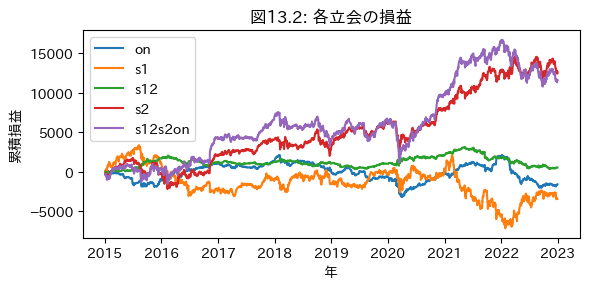

In [8]:
#累積損益のグラフ表示
session.iloc[:,0:5].cumsum().plot(figsize=(6,3))
plt.legend(loc='upper left')
plt.ylabel('累積損益')
plt.xlabel('年')
plt.title('図13.2: 各立会の損益')
plt.tight_layout()
#plt.savefig('図13.2.jpeg',dpi=600)
plt.show()

　図13.2のs12s2onは、日経平均株価から得られた日中立会の引けからつぎの日の日中立会の寄り付きまでの価格の動きである。ではいよいよ、日経平均株価と比較してみよう。

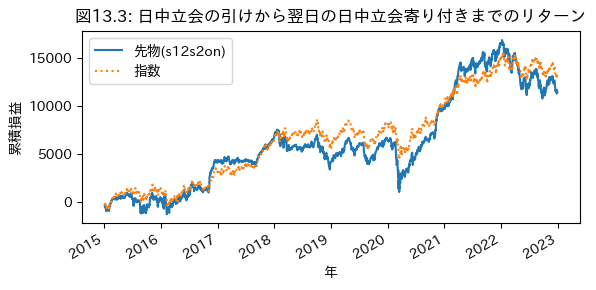

In [9]:
fig=plt.figure(figsize=(6,3))
analysis0=analysis.loc["2015/1/1":"2022/12/31"].copy()
(session.on+session.s12+session.s2).cumsum().plot(label='先物(s12s2on)')
analysis0.overnight.cumsum().plot(label='指数',style=":")
plt.ylabel('累積損益')
plt.xlabel('年')
plt.legend()
plt.title('図13.3: 日中立会の引けから翌日の日中立会寄り付きまでのリターン')
plt.tight_layout()
#plt.savefig('図13.3.jpeg',dpi=600)
plt.show()

　図13.3から、先物とその原資産である日経平均株価の動きにはそれなりの乖離がある。これでは裁定取引が可能となってしまう。しかし、日経平均株価そのものは取引できないのであるから、裁定取引もできないのである。さて、この乖離の原因であるが、それは何であろうか？それは寄り付きと同時にすべての日経平均株価に採用されている銘柄の取引が成立しない場合があるからだ。もし、成立していなければ日経平均株価はルールにしたがって、前日の終値を採用する。しかし、先物のトレーダーはまだ取引の成立していない気配値をベースに予測を立て、先物取引をすると予想できる。だから乖離が生じるのだ。つまり、日経平均株価で計算した日中立会の終値-始値(s1)も信用できないということだ。

　現時点で私たちにできることは、日経平均株価の始値はバックテストには使えないので、日経225先物取引の過去データを使ってバックテストを行うことだ。図13.3を見てみると、途中で大きく乖離してしまう場面もあるが、長期的には、絡み合いながら同じような方向で動いている。


13.2.5 記述統計

　pandasのdescribeを用いて、基本統計量を取得する。

In [10]:
pd.options.display.precision = 2
factors=['データ数','平均','標準偏差','最小値','4分位点(25%)',
         '4分位点(50%)','4分位点(75%)','最大値','取引の長さ']
da=['日中立会','日中立会-夜間立会','夜間立会','オーバーナイト','s12s2on']
results=[session.s1.describe(),session.s12.describe(),session.s2.describe(),\
         session.on.describe(),session.s12s2on.describe()]
results=pd.DataFrame(results,index=da)
print('表13.2: 各立会、立会間の価格差の基本統計量')
results

表13.2: 各立会、立会間の価格差の基本統計量


,count,mean,std,min,25%,50%,75%,max
日中立会,1957.0,-1.77,189.87,-1335.0,-90.0,5.0,100.0,825.0
日中立会-夜間立会,1957.0,0.26,55.15,-740.0,-20.0,0.0,25.0,400.0
夜間立会,1957.0,6.39,177.51,-1165.0,-75.0,10.0,100.0,795.0
オーバーナイト,1957.0,-0.82,94.29,-840.0,-30.0,0.0,35.0,470.0
s12s2on,1957.0,5.95,206.67,-1575.0,-95.0,10.0,120.0,1000.0


　表13.2から基本的な特性が見て取れる。日中立会(s1)とオーバーナイト(on)では累積価格差はマイナスであり、日中立会とや夜間立会の間(s12)と夜間立会(s2)、そして日中立会の引けから夜間立会の寄り付まで(s12s2on)の累積価格差はプラスである。標準偏差はs12s2onが最も大きく、つぎに日中立会につづく。

13.2.6 各種統計的検定による価格差の特性の確認

　ADF検定で各価格差の非定常性を確認し、t検定で平均値がゼロよりどの程度大きいかを評価し、JBで正規性の検定を行った。t検定のp値は大きければ平均値がプラスである可能性が高まる。

In [11]:
summary=[]
sessions=[session.s1,session.s12,session.s2,session.on,session.s12s2on]
tests=['n','c','ct']
factors=['標本の大きさ']+tests+['tテスト','JB','歪度','尖度']
da=[]
for data in sessions:
    results=[len(data)]
    da.append(data.name)
    for i in tests:
        results.append(sm.tsa.adfuller(data,regression=i)[1])
    tvalue=(data.mean()/data.std()*np.sqrt(data.count()))
    ttest=t.cdf(tvalue,int(len(data)-1))
    results.append(ttest)
    results.append(sms.jarque_bera(data)[1])
    results.append(data.skew())
    results.append(data.kurt())
    summary.append(results)
print('表13.3: 各立会、立会間の価格差の特性')
summary=pd.DataFrame(summary,index=da,columns=factors)
summary

表13.3: 各立会、立会間の価格差の特性


,標本の大きさ,n,c,ct,tテスト,JB,歪度,尖度
s1,1957,0.00e+00,0.00e+00,0.00e+00,0.34,0.00e+00,-0.69,4.28
s12,1957,0.00e+00,0.00e+00,0.00e+00,0.58,0.00e+00,-1.55,23.72
s2,1957,0.00e+00,0.00e+00,0.00e+00,0.94,1.63e-183,-0.28,3.17
on,1957,8.75e-15,4.06e-14,1.68e-12,0.35,0.00e+00,-1.50,14.05
s12s2on,1957,0.00e+00,0.00e+00,0.00e+00,0.90,0.00e+00,-0.64,5.04


　驚くことに、どの立会内、立会間の価格差も単位根をもたないし、正規分布でもない。尖度はときに正規分布からほど遠い。

13.2.6 累積価格差の期間構造

　いよいよ取引戦略を考えるうえで重要な期間構造の分析をしよう。入力[12]では1日2円の取引費用を差し引いている。入力[12]では連続した期間構造のもと、高値、安値、平均値を求めている。

In [12]:
def rolling_returnanalysis(data):
    high=[pd.Series.rolling(data,i).sum().max()-2*i for i in range(120)]
    low=[pd.Series.rolling(data,i).sum().min()-2*i for i in range(120)]
    ave=[pd.Series.rolling(data,i).sum().mean()-2*i for i in range(120)]
    return high, ave,low

In [13]:
def threedataplot(data1,data2,data3,label1,label2,label3,xlabel,ylabel,title):
    plt.figure(figsize=(6,3))
    plt.plot(data1,label=label1,linestyle=':')
    plt.plot(data2,label=label2,color='darkred')
    plt.plot(data3,label=label3,linestyle='--')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    #plt.savefig(title[:5]+'.jpeg',dpi=600)
    plt.show()

　初版では強いトレンドが見られた日中-夜間立会間の価格差を用いた。

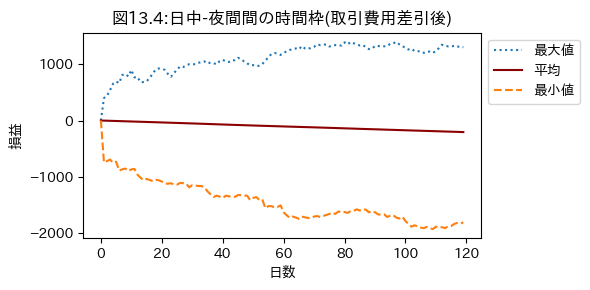

In [14]:
high,ave,low=rolling_returnanalysis(session.s12)
threedataplot(high,ave,low,'最大値','平均','最小値','日数','損益',
              '図13.4:日中-夜間間の時間枠(取引費用差引後)')

改訂版では、本来の目的により、s12s2onを用いる。

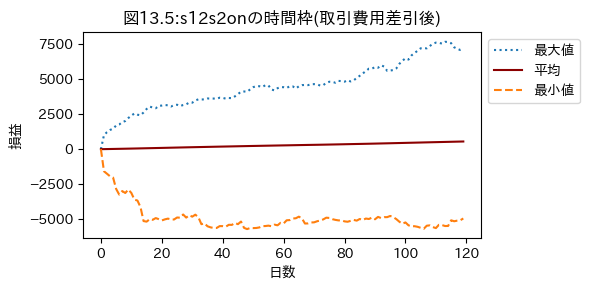

In [15]:
high,ave,low=rolling_returnanalysis(session.s12s2on)
threedataplot(high,ave,low,'最大値','平均','最小値','日数','損益',
              '図13.5:s12s2onの時間枠(取引費用差引後)')

図13.5と図13.6ともに、120日間の取引では利益が出ない確率があり、最大のドローダウンはs12では2000ポイント弱、s12s2onでは5000ポイント近くになる可能性が読み取れる。
 
13.2.7 戦略の改良

 s12s2onは、チャートでの確認において安定した上昇トレンドを示していた。そこで動的分析を用いてドローダウンの原因を探ってみよう。図13.7は移動期間は20日のt値と累積損益を並べたものである。

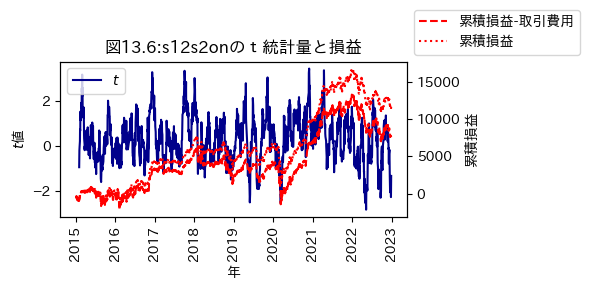

In [16]:
plt.figure(figsize=(6,3))
n=20#移動ｔ値の計算に使うデータの個数
ax=(pd.Series.rolling(session.s12s2on,n).mean()/\
    pd.Series.rolling(session.s12s2on,n).std()*np.sqrt(n))\
    .plot(label='$t$',color='darkblue')#移動t統計量の推定値の算出とプロット
plt.ylabel('$t$値')
plt.xlabel('年')
plt.legend( bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.legend(loc='upper left')
ax2 = ax.twinx()#２番目の目盛りの設定
session['s12s2onc']=session.s12s2on-2#s12c：取引費用込み
ax2=session.s12s2onc.cumsum().plot( style="r--",label='累積損益-取引費用' )
ax2=session.s12s2on.cumsum().plot( style="r:",label='累積損益' )
plt.ylabel('累積損益')
#plt.xticks(rotation=90)
plt.legend(loc='lower left', bbox_to_anchor=(1, 1))  
plt.title('図13.6:s12s2onのｔ統計量と損益')
plt.tight_layout()  
#plt.savefig("図13.6.jpeg",dpi=600)
plt.show()

図13.6のt値は移動t値である。t値のゆらぎの具合がよく分かる。また累積損益は取引費用を差し引いてある。t値と損益の関係を見るために散布図を作ってみよう。

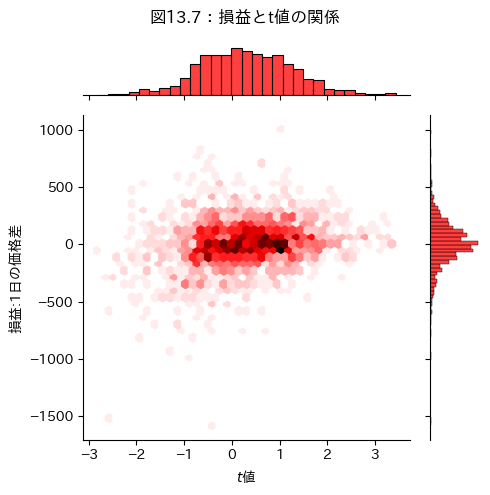

In [17]:
x=(pd.Series.rolling(session.s12s2on,n).mean()/\
    pd.Series.rolling(session.s12s2on,n).std()*np.sqrt(n))
y=session.s12s2on
a=sns.jointplot(x=x,y=y,kind="hex", color="r",height=5)
a.fig.suptitle("図13.7：損益とt値の関係")
plt.xlabel('$t$値')
plt.ylabel('損益:1日の価格差')
plt.tight_layout()
#plt.savefig("図13.7.jpeg",dpi=600)
plt.show()

図13.7より移動t値がマイナスだと、大きな下落の可能性が示唆される。統計的仮説の検定を用いて$T \ge t_{\alpha,5}$が満たされる場合にロングポジションを持つように戦略を改良してみよう。有意水準をいくらに設定するかが問題である。そこで上昇のトレンドは構造的に頑健であるという立場から、有意水準を90%とした。

In [18]:
def doubledata_plotanalysis(pddata1,pddata2,label1,label2,xlabel,ylabel,title):
    plt.figure(figsize=(6,3))
    pddata1.plot(label=label1,linestyle='--')
    pddata2.plot(label=label2,color='darkgreen')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()    
    plt.tight_layout()  
    #plt.savefig(title[:6]+'.jpeg',dpi=600)
    plt.show()

戦略の価格差の標準偏差206.74


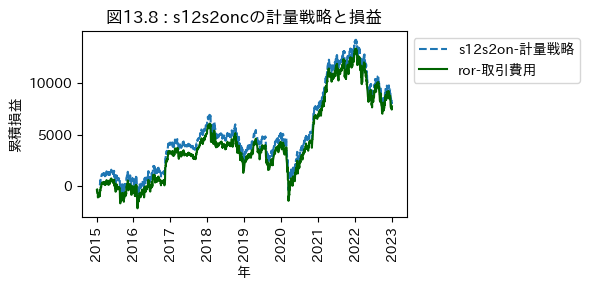

In [19]:
n=20#移動ｔ値の計算に使うデータの個数
tt=(pd.Series.rolling(session.s12s2on,n).mean()/\
    pd.Series.rolling(session.s12s2on,n).std()\
    *np.sqrt(n)).shift(1).dropna() #移動t値の算出とプロット
#shift(1)を用いて1単位時間前にずらしていることに注意。
#この操作をしないと将来の情報を今使っていることになる。
port=pd.concat([session.s12s2onc,tt],axis=1).dropna()
port.columns=['s12s2onc','t']
t0=t.ppf(0.01,n-1)#t.ppf(x,n)=累積分布関数の逆関数
#n=採択域、nは標本数
pddata1=port.s12s2onc[port.apply(lambda x:x['t']>t0,axis=1)].cumsum()
pddata2=session.s12s2onc.cumsum()
print(f'戦略の価格差の標準偏差{pddata1.diff().std():2.2f}')
doubledata_plotanalysis(pddata1,pddata2,"s12s2on-計量戦略","ror-取引費用",\
                        "年","累積損益",
                        "図13.8 : s12s2oncの計量戦略と損益")

　図13.8にはこの戦略の結果をs12s2on、単純なロングポジションの結果をrorで表した。取引タイミングの選別は取引費用の削減に貢献している。しかし、この戦略の結果は単純なロングポジションをもつ戦略のものと大して変わらない。ボラティリティが急上昇した時点で取引を一旦停止する戦略に変更してみよう。

戦略の価格差の標準偏差182.56


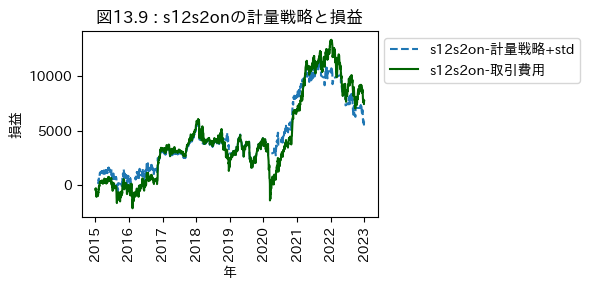

In [20]:
n=20
#１日前の移動標準偏差の算出
ss=pd.Series.rolling(session.s12s2on,n).std().shift(1).dropna()
port=pd.concat([session.s12s2onc,ss],axis=1).dropna()
port.columns=['s12s2onc','std']#列に名前を付ける
s0=chi2.ppf(0.7,n-1)*210/(n-1)#35は真の値の推定値
#採択域は0.8、有意水準は0.1
t0=t.ppf(0.1,n-1)
pdata1=port.s12s2onc[port.apply(lambda x:(x['std']<s0),axis=1)>0].cumsum()
pdata2=session.s12s2onc.cumsum()
print(f'戦略の価格差の標準偏差{pdata1.diff().std():2.2f}')

doubledata_plotanalysis(pdata1,pdata2,"s12s2on-計量戦略+std",
                        "s12s2on-取引費用","年","損益",
                        "図13.9 : s12s2onの計量戦略と損益")

　損益が大きく減少した。標準偏差の初期値を210としてあるが、これは全標本の平均値である。また、有意水準の設定にも戦略の結果は影響を受ける。

　さらに改良が可能である。T検定を行う場合でも標準偏差が一定でなければそれを基準に将来のポジションを取ることに意味はない。そこで、分散不均一性が無いと判断されたときにT検定を用いる方式に変更してみよう。


In [21]:
#トレンドの発生とボラティリティの安定性の判定
def long_stat(s,s0,t,t1):#統計的検定による買いポジションの判定
    stat=False
    if s<s0:#ボラティリティの安定性の判定
        if t>t1:#トレンドの有無の判定
            stat=True
    return stat

In [22]:
def create_port(session,session2,n):
    tt=(pd.Series.rolling(session,n).mean()/pd.Series.rolling(session,n).std()\
        *np.sqrt(n)).shift(1).dropna()
    ss=pd.Series.rolling(session,n).std().shift(1).dropna()
    #費用込みの損益、t値と標準偏差のデータベースの作成
    port=pd.concat([session2,ss,tt],axis=1).dropna()
    port.columns=['ror','s','t']
    return port

戦略の価格差の標準偏差174.20


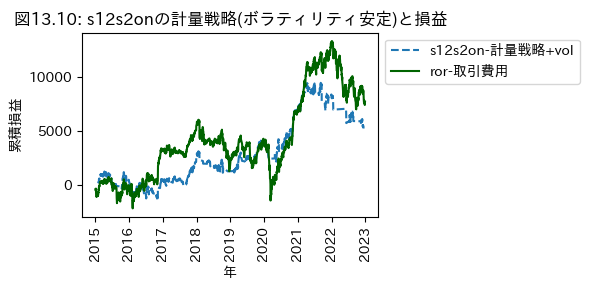

In [23]:
port=create_port(session.s12s2on,session.s12s2onc,n)
n=20
t0=t.ppf(0.4,n-1)#t統計量の算出
s0=chi2.ppf(0.7,n-1)*210/(n-1)#標準偏差の統計量の算出、210は真の値の推定値
pddata1=port.ror[port.apply(lambda x:long_stat(x['s'],s0,x['t'],t0),axis=1)].\
            cumsum()
pddata2=session.s12s2onc.cumsum()
print(f'戦略の価格差の標準偏差{pddata1.diff().std():2.2f}')
doubledata_plotanalysis(pddata1,pddata2,"s12s2on-計量戦略+vol","ror-取引費用",\
            "年","累積損益",
            "図13.10: s12s2onの計量戦略(ボラティリティ安定)と損益")

　収益は落ちたが、標準偏差を下げることができたのでそれなりに目的を達した。

13.2.7 戦略の確認

上述の戦略では慎重さを反映している結果となった。しかし、有意水準を含むその他のモデルのパラメータは試行錯誤の結果である。このままでは戦略の有効性の成否を判断できない。そこで、さらに似たような市場で同じ効果が出るかどうかをチェックしてみよう。結果は順に夜間と日中立会の間(on)、日中立会(s1)、夜間立会(s2)である。結果の判断は読者の方々にお任せする。パラメータはどの立会でも変更することなく使っていることに注意してほしい。それぞれの立会でパラメータを調整することも可能。どの市場においても戦略が機能するようにパラメータを設定することが定石である。


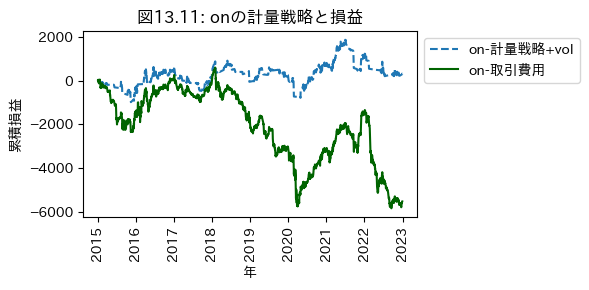

In [24]:
session['on_c']=session.on-2
port=create_port(session.on,session.on_c,n)
n=20
t0=t.ppf(0.4,n-1)
s0=chi2.ppf(0.7,n-1)*115/(n-1)
pddata1=port.ror[port.apply(lambda x:long_stat(x['s'],\
                                               s0,x['t'],t0),axis=1)].cumsum()
pddata2=session.on_c.cumsum()
doubledata_plotanalysis(pddata1,pddata2,"on-計量戦略+vol","on-取引費用",\
                        "年","累積損益",
                        "図13.11: onの計量戦略と損益")

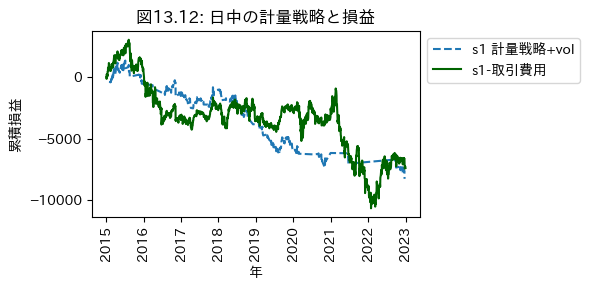

In [25]:
session['s1_c']=session.s1-2
port=create_port(session.s1,session.s1_c,n)
n=20
t0=t.ppf(0.4,n-1)
s0=chi2.ppf(0.7,n-1)*140/(n-1)
pddata1=port.ror[port.apply(lambda x:long_stat(x['s'],\
                                               s0,x['t'],t0),axis=1)].cumsum()
pddata2=session.s1_c.cumsum()
doubledata_plotanalysis(pddata1,pddata2,"s1 計量戦略+vol","s1-取引費用",\
                        "年","累積損益",
                        "図13.12: 日中の計量戦略と損益")

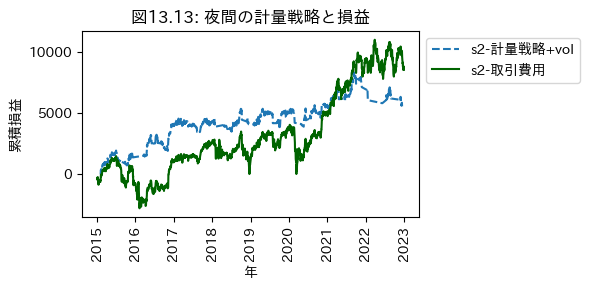

In [26]:
session['s2_c']=session.s2-2
port=create_port(session.s2,session.s2_c,n)
n=20
t0=t.ppf(0.4,n-1)
s0=chi2.ppf(0.7,n-1)*177/(n-1)
pddata1=port.ror[port.apply(lambda x:long_stat(x['s'],\
                        s0,x['t'],t0),axis=1)].cumsum()
pddata2=session.s2_c.cumsum()
doubledata_plotanalysis(pddata1,pddata2,"s2-計量戦略+vol","s2-取引費用",\
                        "年","累積損益",
                        "図13.13: 夜間の計量戦略と損益")

13.3 視点を変える

　時間トレンド、確率的トレンド、定常時系列と統計的手法を駆使して戦略を組み立てて来た。ここで視点を変えて、経験から得られた長い間にわたり採用されている戦略を考えてみよう。そのような戦略の1つがブレイクアウト戦略である。これはトレンド追随型(トレンドフォロー)戦略の代表格である。これを立会における戦略に適用してみよう。

13.3.1 ブレイクアウト戦略

　ブレイクアウト戦略では直前の立会の高値を今の高値が上回ったらポジションを建て、その立会の引けでポジションを閉じるという単純な戦略を考えて見よう。ここで寄り付きが前の立会の高値を上回っていたら、前の高値で買えないので、戦略は成り立たない。


In [27]:
def upperbreakout(price,cost):
    j,s1,s1ch0=0,0,0#初期値設定
    r,da=[],[]#初期値設定
    for i in range(len(price)):
        d=price[i:i+1].index
        hm=price[i:i+1].index.time
        o=price.iloc[i].Open
        h=price.iloc[i].High
        c=price.iloc[i].Close
        if i>0:
            if hm==time(9,0):#日中立会
                s1=c-o#立会の間の値動き
                if h>h0>o:
                    s1ch0=c-h0-cost#ブレイク時の損益
                else:
                    s1ch0=0
            if hm==time(16,30):#夜間立会
                s2=c-o#立会の間の値動き
                if h>h0>o:
                    s2ch0=c-h0-cost#ブレイク時の損益
                else:
                    s2ch0=0
                da.append(datetime(d.year[0],d.month[0],d.day[0]))
                r.append([s1,s1ch0,s2,s2ch0])
        h0=h
    result=pd.DataFrame(r,index=da)
    result.columns=['s1','s1ch0','s2','s2ch0']
    return result

　また、戦略を構築する際には決して将来の情報を使わないようにすることが鉄則である。これを間違えると簡単に収益が得られる戦略が構築されてしまう。ポジションを建てるときはザラバ方式なので売買スプレッドを取引費用として考慮しなければならない。その費用を5とした。ポジションを閉じる際は板寄せ方式なので売買スプレッドはゼロとしている。取引費用は売りと買いの往復で2とした。

戦略の価格差の標準偏差93.67


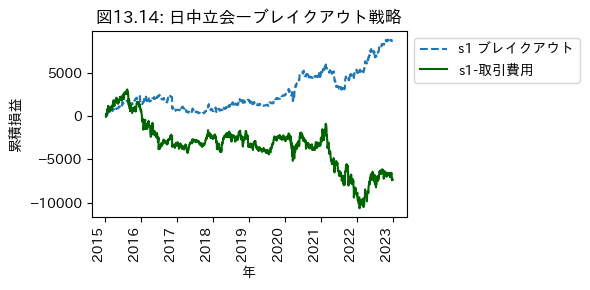

In [28]:
#ブレイクアウト戦略のグラフ表示
cost=5+2
results=upperbreakout(n225fm,cost)
pddata1=results.s1ch0.cumsum()
pddata2=session.s1_c.cumsum()
print(f'戦略の価格差の標準偏差{pddata1.diff().std():2.2f}')
doubledata_plotanalysis(pddata1,pddata2,"s1 ブレイクアウト","s1-取引費用",\
                        "年","累積損益",
                        "図13.14: 日中立会ーブレイクアウト戦略")

　上述のグラフは日中立会の結果である。この戦略の損益の標準偏差は93であり、分散不均一性と上昇トレンドの判定からなるこの前の戦略の標準偏差174よりも低い。

12.3.2 リスク管理戦略

しかし、ここでリスクについて見てみよう。


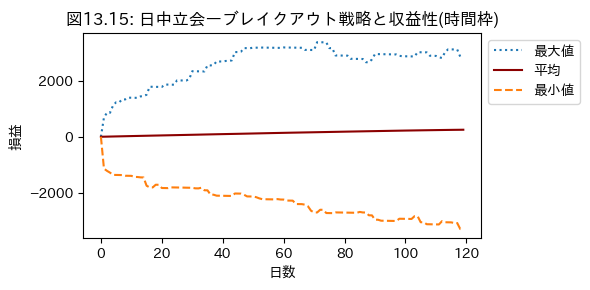

In [29]:
#120日間におけるドローダウン、リスク分析
high,ave,low=rolling_returnanalysis(results.s1ch0)
threedataplot(high,ave,low,'最大値','平均','最小値','日数','損益',
              '図13.15: 日中立会ーブレイクアウト戦略と収益性(時間枠)')

　図13.15からブレイクアウト戦略では半年間の戦略の継続で収益が見込める可能性がある。また、ドローダウン中の最大損失は大きいので注意が必要である。

13.3.3 戦略の改良

　さらにリスクの軽減が図れないか試してみよう。統計的手法と共にブレイクアウト戦略を用いるとどうなるであろうか？興味の湧く実験である。

In [30]:
#統計的検定を用いたブレイクアウト戦略
def tripledata_plotanalysis(pddata1,pddata2,pddata3,\
                            label1,label2,label3,xlabel,ylabel,title):
    plt.figure(figsize=(6,3))
    pddata1.plot(label=label1,linestyle='--')
    pddata2.plot(label=label2,color='darkgreen')
    pddata3.plot(label=label3)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()  
    #plt.savefig(title[:6]+'.jpeg',dpi=600)
    plt.show()

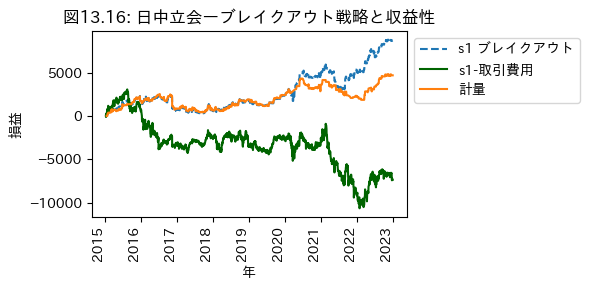

In [31]:
n=5
t0=t.ppf(0.1,n-1)
s0=chi2.ppf(0.7,n-1)*190/(n-1)
tt=(pd.Series.rolling(results.s1,n).mean()/\
    pd.Series.rolling(results.s1,n).std()\
    *np.sqrt(n)).shift(1).dropna()
ss=pd.Series.rolling(results.s1,n).std().shift(1).dropna()
results['t']=tt
results['s']=ss
pddata3=results.s1ch0[results.apply(lambda x:long_stat(x['s'],\
                        s0,x['t'],t0),axis=1)].cumsum()
tripledata_plotanalysis(results.s1ch0.cumsum(),
                        session.s1_c.cumsum(),
                        pddata3,"s1 ブレイクアウト","s1-取引費用","計量",\
                        "年","損益",
                        "図13.16: 日中立会ーブレイクアウト戦略と収益性")

収益は下がるがリスクは軽減されるという期待通りの結果になった。

13.3.4 戦略の確認

戦略の確認に最も良い方法はそのまま他の市場で使ってみることである。ここでは夜間立会に新戦略を適用してみよう。
 
統計的手法の採用でリスクを軽減できる可能性は高い。パラメータは日中立会のときと同じでありパラメータの調整は何もしていない。

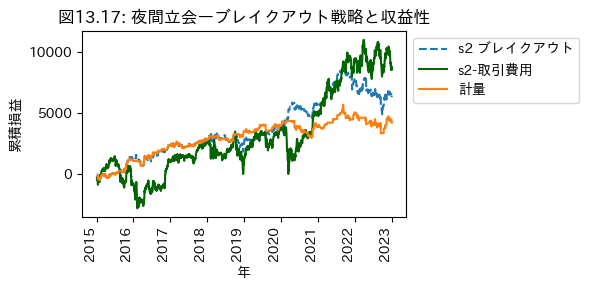

In [32]:
n=5
t0=t.ppf(0.1,n-1)
s0=chi2.ppf(0.7,n-1)*177/(n-1)
tt=(pd.Series.rolling(results.s2,n).mean()/\
    pd.Series.rolling(results.s2,n).std()\
    *np.sqrt(n)).shift(1).dropna()
ss=pd.Series.rolling(results.s2,n).std().shift(1).dropna()
results['t']=tt
results['s']=ss
pddata3=results.s2ch0[results.apply(lambda x:long_stat(x['s'],\
                        s0,x['t'],t0),axis=1)].cumsum()
tripledata_plotanalysis(results.s2ch0.cumsum(),
                        session.s2_c.cumsum(),
                        pddata3,"s2 ブレイクアウト","s2-取引費用","計量",\
                        "年","累積損益",
                        "図13.17: 夜間立会ーブレイクアウト戦略と収益性")

12.4 良い制度の利用

調整不可能な戦略パラメータとして売買スプレッドと取引費用がある。日本の先物取引の取引費用は最近低下傾向にある。また、売買スプレッドも国際競争力がある。ここで日経225先物とS&P500 先物を比べてみよう。

|表13.4a:日経225先物とS＆P500先物の違い|
|:---:|

||S&P500E mini|日経225mini|
|:---|:---|:---|
|取引単位|50ドル・SP500指数|100・日経平均株価|  
|呼値の単位|$12.5|500円 |
|指数2016/5/30|2099.06|17068.02|
|呼値の単位/取引単位	|0.000119|	0.000293|  

|表13.4b:日経225先物とS＆P500先物の違い|
|:---:|

||S&P500先物|日経先物取引|
|:---|:---|:---|
|取引単位|250ドル・SP500指数	|1000・日経平均株価|    
|呼値の単位|	25ドル|	1000円|
|指数2016/5/30|	2099.06|	17068.02|  
|呼値の単位/取引単位	|0.000048|0.000059| 

2つの表から明らかなように、呼値の単位（きざみ）を取引単位と比較した場合、一般に取引単位が大きいほうが有利である。日本の日経平均株価の先物はラージもミニもS&P500の先物と比較して決して高くはなく、むしろ割安である。この優位性は生かすしかない。